In [28]:
#SETUP
#import get to call a get request on the site
from requests import get
from bs4 import BeautifulSoup

#get the first page of the Montreal housing
response = get('https://montreal.craigslist.org/search/apa?hasPic=1&availabilityMode=0&sale_date=all+dates&lang=en&cc=us')

#create a BeautifulSoup object
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the listing container
listings = html_soup.find_all('li', class_='result-row')


In [29]:
#CHECKS

#checking if find_all is resturning a result set
print(type(listings))
#checking if appropriate number of results
print(len(listings))


<class 'bs4.element.ResultSet'>
120


In [30]:
#PARSING ONE POST

#grab the first listing
listing_one = (listings[0])
#check HMTL contents of one listing
print(listings[0])

#grab the first listing's price
listing_one_price = listing_one.a.text
listing_one_price.strip()
print(listing_one_price)

#grab the time and datetime it was posted
listing_one_time = listing_one.find('time', class_='result-date')
listing_one_datetime = listing_one_time['datetime']
print(listing_one_datetime)

#grab URL and post title
listing_one_title = listing_one.find('a', class_="result-title hdrlnk")
listing_one_URL = listing_one_title['href']
listing_one_title = listing_one_title.text

#grab apartment characteristics (number of bedrooms, sqft, hood)
listing_one_num_bedrooms =  listing_one.find('span', class_='housing').text.split()[0]
listing_one_num_sqft = listing_one.find('span', class_='housing').text.split()[2][:-3] #cleaning ft^2 from the end of the string (ommit last 3 characters from string in third string item of list)
listing_one_num_hood = listing_one.find('span', class_='result-hood').text

print(listing_one_num_bedrooms)
print(listing_one_num_sqft)


<li class="result-row" data-pid="7140890124" data-repost-of="7115632747">
<a class="result-image gallery" data-ids="1:00404_jptV8YYv2aK,1:00x0x_lC6dHhhfHto,1:00p0p_bdDD3LtVwLK,1:00x0x_6RkyUe83q9Q,1:00404_flDTzrBeDI2,1:00l0l_j6xrMem8LUt,1:00808_cJ89jFcEjhb,1:00m0m_5lk8yqxGdL1,1:00606_f7C8bmhKEcD,1:00t0t_12StWZ8BSH8,1:00t0t_6xPmf3tgdFj,1:00505_5M0AmVAkDMA,1:00b0b_489WnXeIHLt,1:00M0M_1cXLii26Tc3,1:00T0T_l4cFnQr9vRy,1:00U0U_9T0vpKcj6O2,1:01111_e5DkQo8yKtw,1:00M0M_7TYV0Rzo1ZU,1:00c0c_bCj6LbDhnkr,1:00u0u_iMkOOuYGcrm,1:01111_1RWgRzddrPj,1:00g0g_hYZc6wMt3lM,1:00303_5Q9FuFpLzHI,1:01111_2t3z332ZiNq" href="https://montreal.craigslist.org/apa/d/montreal-3-bedroom-luxury-appartment/7140890124.html?lang=en&amp;cc=us">
<span class="result-price">$2900</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-06-13 01:42" title="Sat 13 Jun 01:42:55 AM">Jun 13</time>
<a clas

IndexError: list index out of range

In [31]:
#BUILDING THE LOOP

#setup
from time import sleep
import re #regulat expressions
from random import randint #avoid throttling by not sending too many requests one after the other
from IPython.core.display import clear_output
import numpy as np 

#find the total number of listings to find the number of loop iterations
search_header = html_soup.find('div', class_= 'search-legend')
results_total = int(search_header.find('span', class_='totalcount').text) # upper bound of the number of listings

#each page has 119 posts, a new page is defined as a multiple of 120
pages = np.arange(0, results_total + 1, 120)

iterations = 0

listing_time = []
listing_hoods = []
listing_title_texts = []
bedroom_counts = []
sqfts = []
listing_links = []
listing_prices = []


In [32]:
for page in pages:

    #get request
    response = get('https://montreal.craigslist.org/search/apa?'
        + 's=' #URL parameter defining the page number
        + str(page) #the page number in the pages array created with np.arange
        + '&hasPic=1' #making sure all listings have photos
        + '&availabilityMode=0&sale_date=all+dates&lang=en&cc=us') #the other parameters (e.g. language, etc.)

    sleep(randint(1,5)) # waiting a bit to avoid throttling

    #create BeautifulSoup object with response
    page_html = BeautifulSoup(response.text, 'html.parser')

    #define the listings
    listings = html_soup.find_all('li', class_='result-row')

    #extract listings characteristics
    for listing in listings:
        if listing.find('span', class_= 'result-hood') is not None:
            # listing_timing
            listing_datetime = listing.find('time', class_= 'result-date')['datetime']
            listing_time.append(listing_datetime)
    
            # listing_hoods
            listing_hood = listing.find('span', class_='result-hood').text
            listing_hoods.append(listing_hood)
            
            # listing_title_texts
            listing_title = listing.find('a', class_='result-title hdrlnk')
            listing_title_text = listing_title.text
            listing_title_texts.append(listing_title_text)
            
            # listing_links
            listing_link = listing_title['href']
            listing_links.append(listing_link)
            
            # listing_prices
            listing_price = int(listing.a.text.strip().replace('$','')) # removes the dollar sign, turns value to integer
            listing_prices.append(listing_price)
            
            #the next two characteristics (bedroom_counts and sqfts) are not always present in a listing, I am hence creating an 'if' clause

            if listing.find('span', class_= 'housing') is not None:
                #if the first element is sqft
                if 'ft2' in listing.find('span', class_='housing').text.split()[0]:
                    #make bedroom count NaN
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)

                    #make sqft the first element
                    sqft = int(listing.find('span', class_='housing').text.split()[0][:-3])
                    sqfts.append(sqft)

                #if the length of the housing details element is more than 2 (implying there is both bedroom_count and sqft)
                elif len(listing.find('span', class_='housing').text.split()) > 2:

                    #element 0 would be bedroom_count
                    bedroom_count = listing.find('span', class_='housing').text.replace('br','').split()[0]
                    bedroom_counts.append(bedroom_count)

                    #and element 2 would be sqft
                    sqft = listing.find('span', class_='housing').text.split()[2][:-3]
                    sqfts.append(sqft)

                #if there is a number of bedroom but no sqft, the number of elements will be 2
                elif len(listing.find('span', class_='housing').text.split()) == 2:

                    # element 0 would be bedroom count
                    bedroom_count = listing.find('span', class_='housing').text.replace('br','').split()[0]
                    bedroom_counts.append(bedroom_count)

                    # and element 2 would be sqft, but is NaN
                    sqft = np.nan
                    sqfts.append(sqft)

                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)

                    sqft = np.nan
                    sqfts.append(sqft)
            
            #if none of these conditions work, make bedroom_count and sqft NaN
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)

                sqft = np.nan
                sqfts.append(sqft)

    iterations +=1
    print('Page ' + str(iterations) + ' scraped succesfully.')

print('\n')

print('Scrape complete! ' + str(iterations) + ' pages scraped.')


Page 1 scraped succesfully.
Page 2 scraped succesfully.
Page 3 scraped succesfully.
Page 4 scraped succesfully.
Page 5 scraped succesfully.
Page 6 scraped succesfully.
Page 7 scraped succesfully.
Page 8 scraped succesfully.
Page 9 scraped succesfully.
Page 10 scraped succesfully.
Page 11 scraped succesfully.
Page 12 scraped succesfully.
Page 13 scraped succesfully.
Page 14 scraped succesfully.
Page 15 scraped succesfully.
Page 16 scraped succesfully.
Page 17 scraped succesfully.
Page 18 scraped succesfully.
Page 19 scraped succesfully.
Page 20 scraped succesfully.
Page 21 scraped succesfully.
Page 22 scraped succesfully.
Page 23 scraped succesfully.
Page 24 scraped succesfully.
Page 25 scraped succesfully.
Page 26 scraped succesfully.


Scrape complete! 26 pages scraped.


In [33]:
# CREATING A DATAFRAME

# setup

import pandas as pd

# creating dataframe and naming variables

mtl_apts = pd.DataFrame({'posted': listing_time,
                        'neighborhood': listing_hoods,
                        'listing_title': listing_title_texts,
                        'number_bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': listing_links,
                        'price': listing_prices})

print(mtl_apts.info())
mtl_apts.head(10)

#save to csv
mtl_apts.to_csv('mtl_apts.csv', encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912 entries, 0 to 2911
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   posted           2912 non-null   object
 1   neighborhood     2912 non-null   object
 2   listing_title    2912 non-null   object
 3   number_bedrooms  2522 non-null   object
 4   sqft             1404 non-null   object
 5   URL              2912 non-null   object
 6   price            2912 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 159.4+ KB
None


In [59]:
mtl_apts.head(10)
len(mtl_apts['listing_title'].unique())
mtl_apts['neighborhood'].unique()

array([], dtype=object)

In [60]:
# DATA CLEANING

# drop duplicate URLs, which are spam
mtl_apts = mtl_apts.drop_duplicates(subset='URL')
len(mtl_apts.drop_duplicates(subset='URL'))

0

In [61]:
# make number_bedrooms a float
mtl_apts['number_bedrooms'] = mtl_apts['number_bedrooms'].apply(lambda x: float(x))

In [52]:
# convert "posted" string into a datetime object
from datetime import datetime

mtl_apts['posted'] = pd.to_datetime(mtl_apts['posted'])

In [53]:
# Cleaning up "neighborhood"

# Removing parentheses using a lambda function, and the map() method

mtl_apts['neighborhood'] = mtl_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

# Titlecase the neighborhoods
mtl_apts['neighborhood'] = mtl_apts['neighborhood'].str.title()

# If neighbourhoods with multiple names, only take the first one
mtl_apts['neighborhood'] = mtl_apts['neighborhood'].apply(lambda x: x.split('/')[0])

# Fix one-offs
mtl_apts['neighborhood'].replace('HOMA', 'Hochelaga', inplace=True)
mtl_apts['neighborhood'].replace('Centre Ouest- Ville Marie', 'Ville-Marie', inplace=True)
mtl_apts['neighborhood'].replace('Le Plateau Mont-Royal', 'Le Plateau', inplace=True)
mtl_apts['neighborhood'].replace('1025 Rue De La Commune .E	', 'Ville-Marie', inplace=True)
mtl_apts['neighborhood'].replace('1288 Av. Des Canadiens-De-Montréal', 'Ville-Marie', inplace=True)
mtl_apts['neighborhood'].replace('1414 Rue Chomeday', 'Ville-Marie', inplace=True)
mtl_apts['neighborhood'].replace('1450 Boul. René-Lévesque O.	', 'Ville-Marie', inplace=True)

# Remove whitespaces
mtl_apts['neighborhood'] = mtl_apts['neighborhood'].apply(lambda x: x.strip())

# add merge data set with clean_neighborhoods (which was built by hand)
mtl_clean_hoods = pd.read_csv('clean_location.csv')
mtl_apts = pd.merge(mtl_apts, mtl_clean_hoods, on='neighborhood', how='inner')

# save the cleaned and merged dataframe
mtl_apts.to_csv('mtl_apts_clean_09062020.csv', index=False)




In [54]:
# DATA ANALYSIS

# load the .csv file
mtl_apts = pd.read_csv('mtl_apts_clean_09062020.csv')

In [55]:
# Data analysis

mtl_apts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   posted                0 non-null      object
 1   listing_title         0 non-null      object
 2   number_bedrooms       0 non-null      object
 3   sqft                  0 non-null      object
 4   URL                   0 non-null      object
 5   price                 0 non-null      object
 6   clean_neighborhood_x  0 non-null      object
 7   clean_neighborhood_y  0 non-null      object
 8   neighborhood          0 non-null      object
 9   clean_neighborhood    0 non-null      object
dtypes: object(10)
memory usage: 0.0+ bytes


Text(0.5, 1.0, 'Distribution of Prices')

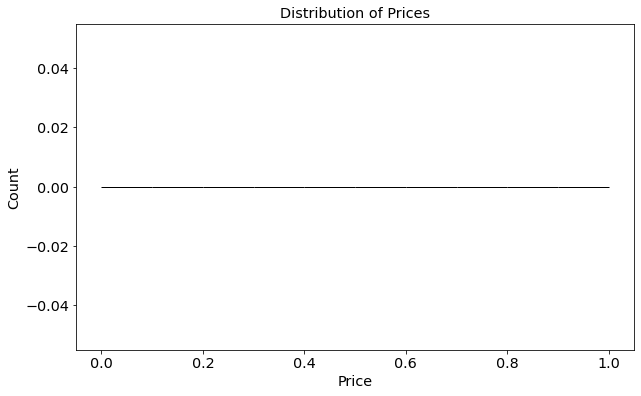

In [56]:
# setup for analysis

import pandas as pd, numpy as np
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot distribution of prices

plt.figure(figsize=(10,6))
plt.hist(mtl_apts['price'], edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Prices')



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Prive vs. Square Footage Colored by Number of Bedrooms')

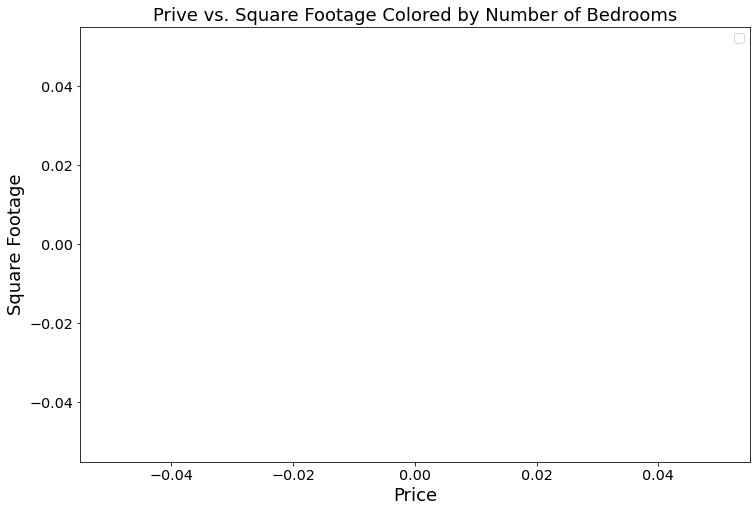

In [57]:
# generate scatterplot displaying price, number of bedrooms, and sqft

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# ordering sqft so scatter plot looks nice
mtl_apts['sqft'] = mtl_apts['sqft'].astype(float)
mtl_apts.sort_values(by=['sqft'], inplace=True)

# generating scatterplot
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='sqft', hue='number_bedrooms', palette='summer', x_jitter=True, y_jitter=True,s=125, data=mtl_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel('Price', fontsize=18)
plt.ylabel('Square Footage', fontsize=18)
plt.title('Prive vs. Square Footage Colored by Number of Bedrooms', fontsize=18)



Text(0, 0.5, 'Square Feet')

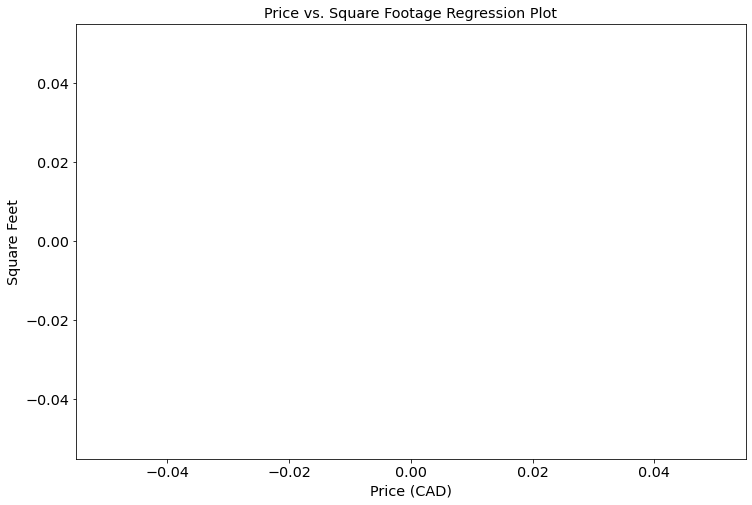

In [43]:
# fitting a regression model, plotting it

plt.figure(figsize=(12,8))
sns.regplot(x='price', y='sqft', data=mtl_apts.dropna())
plt.title('Price vs. Square Footage Regression Plot')
plt.xlabel('Price (CAD)')
plt.ylabel('Square Feet')


In [44]:
mtl_apts.corr()

,sqft
sqft,NaN


In [45]:
mtl_apts.groupby('clean_neighborhood').mean()

,sqft
clean_neighborhood,


In [46]:
mtl_apts.groupby('clean_neighborhood').mean()['price'].sort_values()

KeyError: 'price'

In [47]:
# Plotting Boxplots

plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='clean_neighborhood', y='price', data=mtl_apts)
plt.xlabel('Neighborhood')
plt.xticks(rotation=75)
plt.ylabel('Price CAD')
plt.title('Price by Neighborhood - Boxplots')

ValueError: min() arg is an empty sequence